


#### Topics: Sparsity (PCA and Compressive Sensing)
#### Assigned: Wednesday May 23
#### Due: Sunday June 10 by midnight


In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm


# Params
dims = 30
ulength = 7

## Part I PCA

Generate a random vector u in d dimensions as follows: The components of u are i.i.d., with
- P [u[i] = 0] = 2=3; P [u[i] = +1] = 1=6; P [u[i] = −1] = 1=6




In [2]:
# Generate the IID 
def generateMultiDimGaussian(d, ulength):
    u = np.ndarray((ulength,d))
    angles = np.zeros((ulength,ulength))
    deviation = 10    
    while np.amax(angles+90*np.eye(ulength)) > (90+deviation) or np.amin(angles+90*np.eye(ulength)) < (90-deviation):
        for i in range(ulength):
            for j in range(d):
                r = np.random.rand()
                if(r<4/6):
                    u[i,j] = 0
                elif(r<5/6):
                    u[i,j] = 1
                else:
                    u[i,j] = -1
        if(u.any(axis=1).all()):
            for i in range(ulength):
                for j in range(i):
                    angles[i,j] = np.arccos(  np.clip( np.dot(u[i,:]/np.linalg.norm(u[i,:]), u[j,:]/np.linalg.norm(u[j,:]))  ,-1.0,1.0))/np.pi*180
                    angles[j,i] = angles[i,j]
    #print(angles)
    return u

# Uj be i.i.d
Uj = generateMultiDimGaussian(dims, ulength)
print(Uj.shape)

(7, 30)


Generate d-dimensional data samples for a Gaussian mixture distribution with 3 equiprobable components
- Zm  : Standard Gaussian (N(0, 1)) distribution
- N   : noise vector" N ∼ N(0, σ2Id) (default value σ2 = 0:01)
- Component 1: Generate X = u1 + Z1u2 + Z2u3 + N.
- Component 2: Generate X = 2u4 + sqrt(2)Z1u5 + Z2u6 + N.
- Component 3: Generate X = sqrt(2)u6 + Z1(u1 + u2) + (1/sqrt(2))Z2u5 + N

In [3]:

""" 
Generate the higher dimension dataset and sample equiprobable from components
"""
def generateDataset(u, num_data = 50, d = 30):
    sigma_sq = 0.01
    print('\nX(Nxd):',num_data,"x",d,',\tUj:',Uj[0].shape)
    dataset = np.ndarray((num_data,d))
    labels  = np.zeros((num_data,3))  # will be containing [0,1,0] one hot value    
    # Assign the values based on the three component function
    for i in range(0, num_data):
        # Random numbers Zm {Z1, Z2} and N are drawn afresh
        Z1 = np.random.normal()
        Z2 = np.random.normal()
        noise = np.random.multivariate_normal(np.zeros(d), (sigma_sq)*np.eye(d))  
        # choose which comnponent to pick from 
        idx_comp = np.random.choice([0, 1, 2],1,p=[0.333, 0.333, 0.334])
        if(idx_comp == 0):   # Sample from component 1
            dataset[i,:] = Uj[1,:] + Z1*Uj[2,:] + Z2*Uj[3,:] + noise
        elif(idx_comp == 1): # Sample from component 3
            dataset[i,:] = 2*Uj[4,:] + np.sqrt(2)*Z1*Uj[5,:] + Z2*Uj[6,:] + noise
        elif(idx_comp == 2): # Sample from component 3
            dataset[i,:] = np.sqrt(2)*Uj[6,:] + Z1*(Uj[1,:] + Uj[2,:]) + 1/np.sqrt(2) *Z2*Uj[5,:] + noise
        # Assign a label
        labels[i,idx_comp]=1
    return dataset, labels

#X_data, Y_hot_labels = generateDataset(Uj, 50, 30)
#print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)

### SVD of the A<sub>(N × d)</sub> data matrix 

A = U Σ V<sup>T</sup>

1. V must diagonalize A<sup>T</sup>A and v<sub>i</sub> are eigenvectors of A<sup>T</sup>A.
2. Σ where Σ<sub>ii</sub> are singular values of A. 
3. U must diagonalize AA<sup>T</sup> and u<sub>i</sub> are eigenvectors of AA<sup>T</sup> 


X(Nxd): 50 x 30 ,	Uj: (30,)
> X: Data Set: (50, 30) , Y: One hot : (50, 3)
> SD-inp: 1.0707769823735924 
SD-out: 1.070776982373592 
SD-Err: 1.6174861159290205e-15
Singular values  50 × 30  :  [23.84537805 22.55242255 16.75550736 12.16806313 11.83692709  7.97239519
  1.13591013]

X(Nxd): 60 x 30 ,	Uj: (30,)
> X: Data Set: (60, 30) , Y: One hot : (60, 3)
> SD-inp: 1.0687905765656105 
SD-out: 1.0687905765656118 
SD-Err: 1.7373501933504967e-15
Singular values  60 × 30  :  [24.87706368 22.78948735 17.49017239 16.7464921  13.33846154 11.90738655
  1.22541423]

X(Nxd): 80 x 30 ,	Uj: (30,)
> X: Data Set: (80, 30) , Y: One hot : (80, 3)
> SD-inp: 1.132072092455306 
SD-out: 1.132072092455306 
SD-Err: 1.0967106222852883e-15
Singular values  80 × 30  :  [31.10571783 25.31247846 24.37968095 18.12132033 16.82766185 15.64452976
  1.24244821]

X(Nxd): 100 x 30 ,	Uj: (30,)
> X: Data Set: (100, 30) , Y: One hot : (100, 3)
> SD-inp: 1.0647237778126808 
SD-out: 1.0647237778126808 
SD-Err: 1.1910627422500

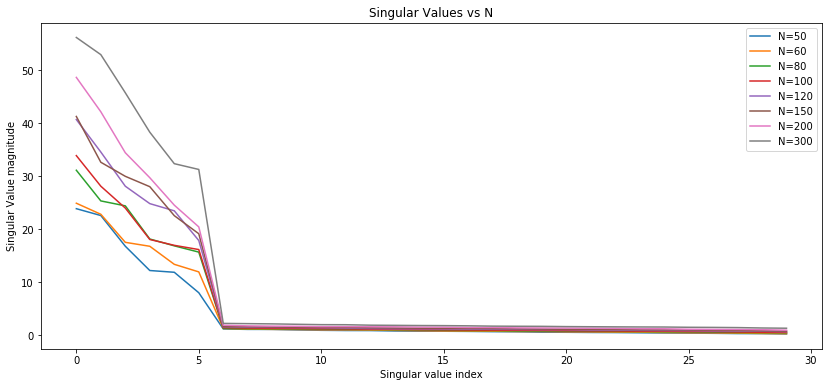

In [10]:
# input sample N=? from components 
def getSingularValues(N = 50, d=30):
    X_data, Y_hot_labels = generateDataset(Uj, N, d)
    print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)
    #Xt = X_data.T
    U, S, V = np.linalg.svd(X_data, full_matrices=False)
    X_a = np.dot(np.dot(U, np.diag(S)), V)
    print("> SD-inp:", np.std(X_data), "\nSD-out:", np.std(X_a), "\nSD-Err:",np.std(X_data - X_a))
    print("Singular values ",N,"×",d," : ",S[0:7])
    return S

plt.figure(figsize=(14,6))
plt.title('Singular Values vs N')
plt.xlabel('Singular value index')
plt.ylabel('Singular Value magnitude')

for Num in [50, 60, 80, 100, 120, 150, 200, 300]:
    S = getSingularValues(Num, dims)
    plt.plot(range(len(S)), S,label = str('N='+str(Num)))
plt.legend()
plt.show()
    
    


### 1.(a)  d<sub>0</sub> = 6 are the dominant singular values
##### we can see this based on the variation for N = [50, 60, 80, 100, 120, 150, 200, 300]



### Now, project the data down to the dominant d0 components to obtain an N × d0 data matrix.

In [11]:
N = 50
X_data, Y_hot_labels = generateDataset(Uj, N, dims)
print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)
U, S, V = np.linalg.svd(X_data, full_matrices=False)
X_a = np.dot(np.dot(U, np.diag(S)), V)
print(">\nSD-inp:", np.std(X_data), "\nSD-out:", np.std(X_a), "\nSD-Err:",np.std(X_data - X_a))
print("Singular values ",N,"×",dims," : ",S[0:7])


d0 = 6 # Dominant vectors d0 = 6 
print("Singular: ", np.diag(S[:d0]).shape)
reconst_matrix = np.dot(U[:,:d0],np.dot(np.diag(S[:d0]),V[:d0,:]))
print(">\nSD-inp:", np.std(X_data), "\nSD-out:", np.std(reconst_matrix), "\nSD-Err:",np.std(X_data - reconst_matrix))


# Using eigen vector V as the basis for projecting the data 
evecs = V[:, :d0]
X_reduced_matrix = np.dot(X_data, evecs)
print("Reduced Matrix[From =",N,"×",dims,"]:" ," To =",X_reduced_matrix.shape)
#print(X_reduced_matrix)


X(Nxd): 50 x 30 ,	Uj: (30,)
> X: Data Set: (50, 30) , Y: One hot : (50, 3)
>
SD-inp: 1.0398341116923444 
SD-out: 1.0398341116923453 
SD-Err: 1.5046286384245243e-15
Singular values  50 × 30  :  [24.93184025 18.23272412 14.97625035 13.60126405 11.64919616 10.64689511
  1.12166722]
Singular:  (6, 6)
>
SD-inp: 1.0398341116923444 
SD-out: 1.0365112612782106 
SD-Err: 0.08316069394885407
Reduced Matrix[From = 50 × 30 ]:  To = (50, 6)


In [12]:
def runKmeansCluster(data, labels, d):
    class_means_dict=dict()
    preds_dict=dict()

    print("Data Dims: ",N,"x",d)
    print("Dataset  : ", data.shape)
    # Kmeans trial 
    for K in range(2,6):
        pred = np.zeros((N, K))
        class_means = np.ndarray((K, d))
        initial_indices = np.random.choice(N,K)

        for k in range(K):
            class_means[k,:] = data[initial_indices[k],:]
        old_class_means = np.zeros((K,d))

        print("\n-------- K=",K,"----------")

        while np.linalg.norm(old_class_means-class_means)/np.linalg.norm(class_means) > 0.001 : 
            norm_mse = np.linalg.norm(old_class_means-class_means)
            norm_mu = np.linalg.norm(class_means)
            #print("> ",norm_mse,"/",norm_mu," \t=\t ",norm_mse/norm_mu)
            old_class_means = np.array(class_means)
            for i in range(N):
                distance_to_means = np.zeros(K)
                for k in range(K):
                    distance_to_means[k] = np.linalg.norm(class_means[k] - data[i])
                #print("Distance: ",distance_to_means)
                nearest_mean = np.argmin(distance_to_means)
                #print("Nearest : ",nearest_mean)
                # labels as the min dist
                pred[i,:] = np.zeros(K)
                pred[i, nearest_mean] = 1 # one hot encoding

            # new mean
            for k in range(K):
                class_means[k] = np.mean(data[np.where(pred[:,k]==1)], axis=0)
            #print("Class MU : ",class_means)

        # save means
        class_means_dict[K] = class_means
        preds_dict[K] = pred
        probabilities = np.ndarray((3,K))  

        for predicted in range(K):
            print('______________________ \n')
            for true_label in range(3):
                interssect = np.intersect1d(np.where(labels[:, true_label] == 1), np.where(pred[:, predicted] == 1))
                tots = np.where(labels[:, true_label] == 1)[0]
                #print('K=',predicted,", idx=",true_label,"\nP -> ",interssect,"\nT ->", tots)
                probabilities[true_label, predicted] = len(interssect) / len(tots)  
                print('K=',predicted,", idx=",true_label,'  -> Prob=%.2f' % probabilities[true_label, predicted])

print("Run on the reduced dimensions data with d0 = ", d0)
runKmeansCluster(X_reduced_matrix, Y_hot_labels, d0)

Run on the reduced dimensions data with d0 =  6
Data Dims:  50 x 6
Dataset  :  (50, 6)

-------- K= 2 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=1.00
K= 0 , idx= 2   -> Prob=0.00
______________________ 

K= 1 , idx= 0   -> Prob=1.00
K= 1 , idx= 1   -> Prob=0.00
K= 1 , idx= 2   -> Prob=1.00

-------- K= 3 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.50
K= 0 , idx= 2   -> Prob=0.00
______________________ 

K= 1 , idx= 0   -> Prob=0.00
K= 1 , idx= 1   -> Prob=0.50
K= 1 , idx= 2   -> Prob=0.00
______________________ 

K= 2 , idx= 0   -> Prob=1.00
K= 2 , idx= 1   -> Prob=0.00
K= 2 , idx= 2   -> Prob=1.00

-------- K= 4 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.00
K= 0 , idx= 2   -> Prob=1.00
______________________ 

K= 1 , idx= 0   -> Prob=0.82
K= 1 , idx= 1   -> Prob=0.05
K= 1 , idx= 2   -> Prob=0.00
______________________ 

K= 2 , idx= 0   -> Prob=0.

## Part II : Random Projections and Compressed Sensing

##### 3.
#####  (a.) Generate m x d matrix Φ, IID drawn such as P [Φij = +1] = 1/2; P [Φij = −1] = 1/2
#####  (b.) Compressive Projection,  y = 1/sqrt(m) * ( Φ x ) with sparse reconstruction of s based on y


In [54]:
def generatePhiMatrix(m, d):
    u = np.ndarray((m,d))
    for i in range(m):
        for j in range(d):
            r = np.random.rand()
            if(r<1/2):
                u[i,j] = 1
            else:
                u[i,j] = -1
    print("Φ(mxd):",u.shape)
    return u

def getCompressedProjection(m = 50, d=30, log=False):
    # Keeping dimensions as dimensions d = 30 and number of data N = 50
    Xp_data, Zp_hot_labels = generateDataset(Uj, m, d)
    # Generate Phi
    phi = generatePhiMatrix(m,d)

    # Compressive Projections
    Y_xp =  (1/np.sqrt(m)) * np.matmul(Xp_data,  phi.T)
    if(log == True):
        print("Compressive Projection: Y = ",Y_xp.shape)

    U, S, V = np.linalg.svd(Y_xp, full_matrices=False)
    Y_xp_a = np.dot(np.dot(U, np.diag(S)), V)
    if(log == True):
        print(">\nSD-inp:", np.std(Y_xp), "\nSD-out:", np.std(Y_xp_a), "\nSD-Err:",np.std(Y_xp - Y_xp_a))

    B_evecs = V[:, :6]
    if(log == True):
        print("______ Singular values ______ \n",S[0:6])
        print("______ Basis Vector (B)______ \n B = [u1\tu2\tu3\tu4\tu5\tu6]\n",B_evecs.shape)

    # Using eigen vector V as the basis for projecting the data 
    #Y_xp_reduced_matrix = np.dot(Y_xp_a, B_evecs)
    #if(log == True):
    #    print("Y Reduced [From =",Y_xp_a.shape,"]:" ," To =",Y_xp_reduced_matrix.shape)
    
    #B_phi_matrix =  (1/np.sqrt(m)) * np.matmul(phi,  B_evecs)
    
    #print(Y_xp_reduced_matrix)
    return "", Zp_hot_labels, B_evecs

M = 50
Y_xp_reduced_matrix, Zp_hot_labels, B_evecs = getCompressedProjection(M, dims, True)



X(Nxd): 50 x 30 ,	Uj: (30,)
Φ(mxd): (50, 30)
Compressive Projection: Y =  (50, 50)
>
SD-inp: 0.9394168428276526 
SD-out: 0.9394168428276526 
SD-Err: 1.9372439949387315e-15
______ Singular values ______ 
 [28.56108362 23.29388618 18.06281067 15.22500256 13.50519773  9.87781149]
______ Basis Vector (B)______ 
 B = [u1	u2	u3	u4	u5	u6]
 (50, 6)


### 4. Lasso problem (using sklearn.linear_model.Lasso)

- Φ = projection matrix also called A in examples 
- x = latent data variables with gaussian noise 
- y = observed results (projection matrix is applied on latent data variables and the result has been reduced in dimensions)

In [49]:


from sklearn import linear_model

def normalizedMSE(Y, YH):
     return np.square(Y - YH).mean()

# Keeping dimension fixed and varying M for this
for m in range(2,20):  
    Y_xp_reduced, Zp_labels, B_vec = getCompressedProjection(m, dims, False)
    clf = linear_model.Lasso(alpha =1.0) # Set lambda ( called ’alpha ’ here )
    clf.fit(Y_xp_reduced, Zp_labels) # Fit the reduced Y to the one hot
    a_hat = clf.coef_ # Get a_hat
    s_hat = np.matmul(B_vec, a_hat.T)
    print("Y_red :", Y_xp_reduced.shape, ",\tLabels:",Zp_labels.shape, ",\tB_vec :",B_vec.shape, ",\ta_hat :",a_hat.shape)
    print("->S:",s_hat.shape,"\n", s_hat)
    
    Y_hat = clf.predict(Y_xp_reduced)
    
    print("Results: ",normalizedMSE(Y_hat, Zp_labels))
    
    



X(Nxd): 2 x 30 ,	Uj: (30,)
Φ(mxd): (2, 30)
Y_red : (2, 2) ,	Labels: (2, 3) ,	B_vec : (2, 2) ,	a_hat : (3, 2)
->S: (2, 3) 
 [[ 0.02271615  0.         -0.02271615]
 [ 0.00063415  0.         -0.00063415]]
Results:  0.13466224065459892
Results: 

X(Nxd): 3 x 30 ,	Uj: (30,)
Φ(mxd): (3, 30)
Y_red : (3, 3) ,	Labels: (3, 3) ,	B_vec : (3, 3) ,	a_hat : (3, 3)
->S: (3, 3) 
 [[-0.00939604  0.          0.        ]
 [ 0.01580915  0.          0.        ]
 [-0.00429657  0.          0.        ]]
Results:  0.20897363708210343
Results: 

X(Nxd): 4 x 30 ,	Uj: (30,)
Φ(mxd): (4, 30)
Y_red : (4, 4) ,	Labels: (4, 3) ,	B_vec : (4, 4) ,	a_hat : (3, 4)
->S: (4, 3) 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Results:  0.125
Results: 

X(Nxd): 5 x 30 ,	Uj: (30,)
Φ(mxd): (5, 30)
Y_red : (5, 5) ,	Labels: (5, 3) ,	B_vec : (5, 5) ,	a_hat : (3, 5)
->S: (5, 3) 
 [[-0.00835912  0.00835912  0.        ]
 [-0.0064603   0.0064603   0.        ]
 [ 0.01016111 -0.01016111  0.        ]
 [ 0.00374538 -0.00374538  0.      